In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Lambda, Conv2D
from keras.layers import GlobalAveragePooling2D, Input, Dropout
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image

from keras.optimizers import Adam, RMSprop, SGD
import urllib
from os.path import join
from sklearn import model_selection
from sklearn import metrics

/home/igor/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
path = '/home/igor/projetos/tcc-1/input/'
model_path = path + 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
target_size = (224,224)
NUM_CLASSES = 10
INPUT_SIZE = 224
BATCH_SIZE = 12
EPOCHS = 10
SEED = 1998

In [3]:
def preprocess_img(img):
    vgg_mean = np.array([123.68, 116.779, 103.939], dtype=(np.float32))
    img = (img - vgg_mean)
    return img[:, ::-1] # BGR

### Criando modelo

In [4]:
def create_vgg16(x=None):
    model = Sequential()
    
    # layer to preprocess images
    model.add(Lambda(preprocess_img, input_shape=(224,224,3), output_shape=(224,224,3)))
    #Conv2D(64, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same')
    # conv block 1
    model.add(Conv2D(64, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # conv block 2
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # conv block 3
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # conv block 4
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # conv block 5
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Fully Connected
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))
    
    return model

### Preparando Input

In [5]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(path, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [6]:
labels = pd.read_csv('../input/labels.csv')
submissao = pd.read_csv('../input/sample_submission.csv')

In [7]:
print(labels.shape[0])
print(submissao.shape[0])

10222
10357


In [8]:
selected_breeds = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
selected_breeds

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed']

In [9]:
labels = labels[labels['breed'].isin(selected_breeds)]

In [10]:
labels['value'] = 0
# labels['rank'] = labels.groupby('breed').rank()['id']

In [11]:
labels_pivot = labels.pivot(index='id', columns='breed', values='value').reset_index().fillna(0)
labels_pivot = labels_pivot.set_index('id')

In [12]:
train_data = []
target = pd.DataFrame(columns=selected_breeds)

In [13]:
for x in labels.values:
    train_data.append(read_img(x[0], 'train', (224,224)))
    target.loc[target.shape[0]] = [0,0,0,0,0,0,0,0,0,0]  
    target.loc[target.shape[0]-1][str(x[1])] = 1

In [14]:
initial_model = create_vgg16()
initial_model.load_weights(model_path)

# Truncate and replace softmax layer for transfer learning
x = Dense(10, activation='softmax')(initial_model.layers[-2].output)
model = Model(initial_model.input, x)


for layer in model.layers[:10]:
    layer.trainable = False
for layer in model.layers[10:]:
    layer.trainable = True
    
opt = SGD(lr=10e-5)
model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(train_data),np.array(target),test_size=0.33, random_state=42)

In [16]:
del train_data
del target

In [45]:
print(model)

In [17]:
model.fit(X_train, y=y_train,batch_size=BATCH_SIZE, epochs=EPOCHS, n)

Epoch 1/10
764/764 [==============================] - 879s 1s/step - loss: 2.4458 - acc: 0.2068
Epoch 2/10
764/764 [==============================] - 877s 1s/step - loss: 1.3136 - acc: 0.5877
Epoch 3/10
764/764 [==============================] - 878s 1s/step - loss: 0.7288 - acc: 0.7827
Epoch 4/10
764/764 [==============================] - 877s 1s/step - loss: 0.3948 - acc: 0.9058
Epoch 5/10
764/764 [==============================] - 877s 1s/step - loss: 0.2060 - acc: 0.9686
Epoch 6/10
764/764 [==============================] - 878s 1s/step - loss: 0.1137 - acc: 0.9921
Epoch 7/10
764/764 [==============================] - 878s 1s/step - loss: 0.0691 - acc: 0.9974
Epoch 8/10
764/764 [==============================] - 878s 1s/step - loss: 0.0460 - acc: 0.9987
Epoch 9/10
764/764 [==============================] - 877s 1s/step - loss: 0.0336 - acc: 1.0000
Epoch 10/10
764/764 [==============================] - 878s 1s/step - loss: 0.0258 - acc: 1.0000


In [4]:
loss = [2.4458, 1.3136, 0.7288, 0.3948, 0.2060, 0.1137, 0.0691, 0.0460, 0.0336, 0.0258]
acc = [0.2068, 0.5877, 0.7827, 0.9058, 0.9686, 0.9921, 0.9974, 0.9987, 1.0000, 1.0000]
epocs = [1,2,3,4,5,6,7,8,9,10]

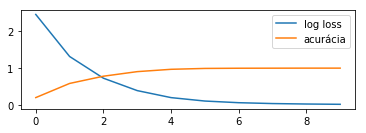

In [39]:
plt.subplot(2, 1, 1)
plt.plot(loss, label="log loss")
plt.plot(acc, label="acurácia")
plt.legend()
plt.show()


ValueError: v must contain [xmin xmax ymin ymax]

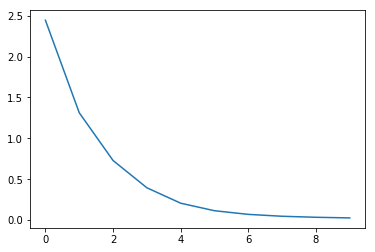

In [24]:
plt.plot(loss)#, acc, epocs)
plt.axis(epocs)
plt.figure()
#plt.plot(acc, label='training accuracy', range=(epocs))
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')

In [18]:
del X_train
del y_train

In [19]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

In [24]:
df = pd.DataFrame(data=y_pred, columns=['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed'])

In [32]:
df

,scottish_deerhound,maltese_dog,afghan_hound,entlebucher,bernese_mountain_dog,shih-tzu,great_pyrenees,pomeranian,basenji,samoyed
0,4.876554e-04,1.624633e-02,1.848588e-01,3.474019e-04,2.441072e-04,3.299939e-01,4.596268e-01,6.553218e-03,8.864859e-04,7.552028e-04
1,1.664882e-07,4.535802e-07,2.172186e-05,8.683285e-01,1.315330e-01,1.374047e-05,3.444421e-06,7.412598e-06,9.092742e-05,6.080245e-07
2,9.142315e-01,1.296406e-03,2.183859e-02,3.794624e-04,5.424058e-02,3.863150e-04,6.899776e-04,4.486603e-03,1.553295e-03,8.972268e-04
3,1.216067e-05,4.871703e-02,8.141982e-02,1.474320e-05,4.844600e-03,8.567235e-01,6.946419e-04,5.810286e-03,1.300046e-04,1.633088e-03
4,4.657730e-02,1.338399e-02,1.718367e-02,1.663530e-04,3.633424e-05,3.142559e-04,9.805745e-04,6.326016e-04,4.421372e-05,9.206807e-01
5,3.374485e-02,3.094226e-04,8.040081e-03,1.627682e-03,1.158118e-05,4.851735e-06,5.702876e-01,2.711789e-04,3.849739e-01,7.288481e-04
6,1.743167e-04,9.893960e-01,1.845909e-04,3.729802e-06,2.143806e-07,9.327191e-03,1.735852e-05,6.022386e-05,4.477178e-05,7.915224e-04
7,2.078677e-01,6.195714e-06,1.496034e-02,3.490457e-02,1.718512e-04,1.253078e-02,1.498056e-02,2.696651e-04,7.142240e-01,8.433016e-05
8,3.912398e-05,1.730866e-07,2.976958e-05,3.552808e-06,4.386091e-08,7.412836e-06,1.608055e-04,1.994892e-06,9.997571e-01,2.878126e-08
9,1.508975e-04,1.579508e-03,7.493004e-03,1.891151e-07,5.321315e-05,2.440923e-04,5.899643e-04,9.898481e-01,2.208566e-06,3.890002e-05


In [22]:
y_pred[0]

array([4.8765537e-04, 1.6246334e-02, 1.8485880e-01, 3.4740189e-04,
       2.4410723e-04, 3.2999390e-01, 4.5962682e-01, 6.5532178e-03,
       8.8648585e-04, 7.5520278e-04], dtype=float32)

In [10]:
# accuracy = metrics.accuracy_score(y_pred, y_test)
# recall = metrics.recall_score(y_pred, y_test)
# precision = metrics.precision_score(y_pred, y_test)

In [ ]:
print(accuracy)
print(recall)
print(precision)

In [11]:
# import pickle
# with open('classifier.pickle', 'wb') as handle: 
#     pickle.dump(model,handle,protocol=pickle.HIGHEST_PROTOCOL) 

In [4]:
import types
import tempfile

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

In [5]:
make_keras_picklable()

In [12]:
# with open('classifier.pickle', 'rb') as handle: 
#     classifier = pickle.load(handle)

In [55]:
classifier.predict(X_test, batch_size=BATCH_SIZE)

array([[4.8765537e-04, 1.6246334e-02, 1.8485880e-01, ..., 6.5532178e-03,
        8.8648585e-04, 7.5520278e-04],
       [1.6648816e-07, 4.5358016e-07, 2.1721857e-05, ..., 7.4125978e-06,
        9.0927424e-05, 6.0802449e-07],
       [9.1423148e-01, 1.2964060e-03, 2.1838594e-02, ..., 4.4866027e-03,
        1.5532954e-03, 8.9722680e-04],
       ...,
       [1.4557450e-05, 7.3999976e-04, 1.0590589e-05, ..., 5.5830336e-05,
        6.9289654e-03, 6.1052160e-06],
       [9.9844247e-01, 1.7100225e-05, 1.1588786e-03, ..., 2.4987914e-04,
        4.6837818e-06, 4.1870371e-05],
       [3.0586693e-09, 1.1619391e-09, 1.1826218e-04, ..., 1.2240216e-09,
        1.2725008e-07, 1.6476949e-07]], dtype=float32)